# Usage Library

In [1]:
import drms

from sunpy.time import TimeRange
from sunpy.instr.goes import get_goes_event_list

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

from IPython.display import display 
import pandas as pd 
from datetime import timedelta, date, datetime

# Create Solar Flare Events (Response Variables)

In [89]:
# Skip if already have the GOES list even
date_from = '2014/02/17 00:00'
date_to = '2015/02/09 23:59'

# Using SunPy to download the GOES flare list and save
time_range = TimeRange(date_from, date_to)
flare_events = pd.DataFrame.from_dict(get_goes_event_list(time_range))
flare_events.to_csv('goes_flare_list1.csv')

KeyboardInterrupt: 

In [110]:
flare_events = pd.read_csv('data/goes_flare_list.csv')
flare_events.dropna(inplace = True)

In [111]:
flare_events.dtypes

start_time      object
end_time        object
peak_time       object
class           object
position        object
noaa_ar_num    float64
dtype: object

In [112]:
time_lag = 12 # in hours

In [113]:
class_mult = {'A':1e-8, 'B':1e-7, 'C':1e-6, 'M':1e-5, 'X': 1e-4}

def convert_class(c):
    cat, score = c[0], float(c[1:])
    
    return score * class_mult[cat]


flare_response = flare_events
flare_response['log_intensity'] = np.log(flare_events['class'].map(convert_class))
flare_response['peak_time'] = drms.to_datetime(flare_response['peak_time'])
flare_response['category'] =  flare_events['class'].map(lambda x: x[0])

flare_res = flare_response[['peak_time', 'noaa_ar_num', 'intensity', 'category']]
flare_res['ptim_lag_bf'] = flare_res['peak_time'].map(lambda t: t - timedelta(hours=time_lag))
flare_res.dropna(inplace=True)
flare_res.drop_duplicates(inplace=True)
flare_res = flare_res[flare_res['noaa_ar_num'] != 0]

/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [114]:
filter_df = datetime(2014, 2, 17)
filter_dt = datetime(2015, 8, 8)

flare_res= flare_res[(flare_res['peak_time'] >= filter_df) & (flare_res['peak_time'] <= filter_dt)]

In [115]:
flare_res.dropna(inplace=True)
display(flare_res.shape)

(1362, 5)

## Solar flares from 2010/1/1 to 2015/12/31

In [113]:
xb = flare_res[(flare_res['intensity'] >= np.log(1e-7)) & (flare_res['intensity'] < np.log(1e-6))]['intensity']
xc = flare_res[(flare_res['intensity'] >= np.log(1e-6)) & (flare_res['intensity'] < np.log(1e-5))]['intensity']
xm = flare_res[(flare_res['intensity'] >= np.log(1e-5)) & (flare_res['intensity'] < np.log(1e-4))]['intensity']
xx = flare_res[(flare_res['intensity'] >= np.log(1e-4)) & (flare_res['intensity'] < np.log(1e-3))]['intensity']

## Histogram for flare intensity of all classes

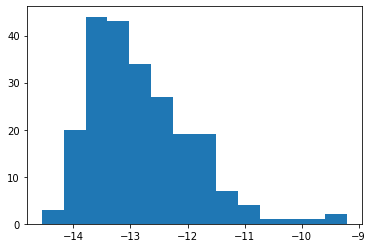

In [114]:
plt.hist(flare_res['intensity'], bins='auto') 
plt.show()

## Histogram for flare intensity class B

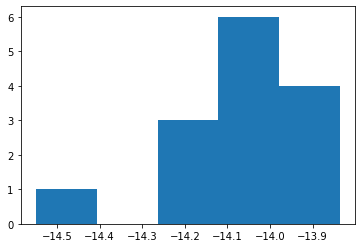

In [66]:
plt.hist(xb, bins='auto') 
plt.show()

## Histogram for flare intensity class C

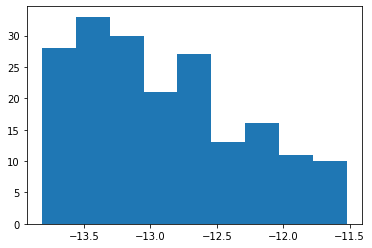

In [67]:
plt.hist(xc, bins='auto') 
plt.show()

## Histogram for flare intensity class M

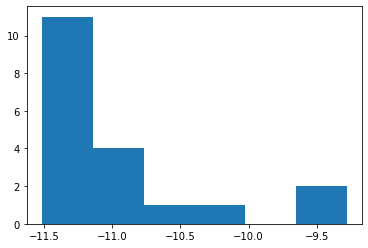

In [68]:
plt.hist(xm, bins='auto') 
plt.show()

## Histogram for flare intensity class X

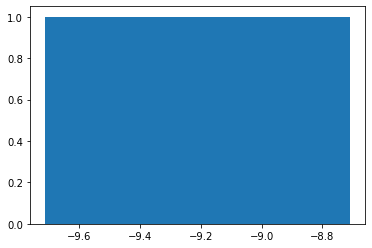

In [69]:
plt.hist(xx, bins='auto') 
plt.show()

# Download SHARP Covariate DataTable

## pull SHARP DRMS data from JSOC

In [9]:
# create a "client"
client = drms.Client()
# Check the data series which match the "sharp"
print(client.series(r'sharp_'))
serie = 'hmi.sharp_cea_720s' # this is what we need

['hmi.sharp_720s', 'hmi.sharp_720s_nrt', 'hmi.sharp_cea_720s', 'hmi.sharp_cea_720s_nrt', 'su_jeneen.sharp_720s', 'su_jeneen.sharp_cea_720s', 'su_mbobra.sharp_loskeys_720s']


In [96]:
flare_raw = client.query('hmi.sharp_cea_720s[][2015.06.10_00:00_TAI/60d@1h]',
    key=drms.const.all)

## create the local SHARP file with relevant covariates

In [97]:
flare_covariates = flare_raw[['T_REC','NOAA_AR','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','ABSNJZH','TOTPOT', 'SIZE_ACR', 'NACR',
                             'MEANPOT', 'SIZE', 'MEANJZH', 'SHRGT45', 'MEANSHR', 'MEANJZD', 'MEANALP', 'MEANGBT',
                             'MEANGAM', 'MEANGBZ', 'MEANGBH']]
flare_covariates = flare_covariates.dropna()
flare_covariates['T_REC'] = drms.to_datetime(flare_covariates['T_REC'])

In [98]:
#flare_covariates.drop_duplicates(subset=['T_REC'], keep = 'first', inplace=True)
flare_covariates = flare_covariates[flare_covariates['NOAA_AR'] != 0]

In [99]:
pd.set_option('display.max_rows', 500)
display(flare_covariates.sort_values(['NOAA_AR','T_REC']).tail(500))

,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,ABSNJZH,TOTPOT,SIZE_ACR,NACR,...,SIZE,MEANJZH,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH
12640,2015-08-07 04:00:00,12394,662.949,1.393230e+13,2.265463e+12,8.688368e+21,98.623,1.661147e+23,1057.739624,11691,...,9976.644531,-0.007405,37.495,39.454,0.129233,-0.015820,110.644,48.738,110.875,64.608
12641,2015-08-07 05:00:00,12394,686.472,1.415365e+13,2.818980e+12,8.988038e+21,104.097,1.644458e+23,1046.610474,11567,...,10004.192383,-0.007469,37.090,39.558,0.269169,-0.016325,110.860,49.111,110.308,64.477
12642,2015-08-07 06:00:00,12394,689.953,1.436837e+13,4.091646e+12,9.427753e+21,104.495,1.673563e+23,1063.864258,11757,...,10037.623047,-0.007068,35.114,38.632,0.440075,-0.016142,110.453,47.532,110.518,63.113
12643,2015-08-07 07:00:00,12394,725.797,1.559201e+13,3.781769e+12,9.854607e+21,104.191,1.694903e+23,1036.300781,11452,...,10048.371094,-0.006407,34.867,38.916,0.429594,-0.015581,108.114,48.019,108.788,59.888
12644,2015-08-07 08:00:00,12394,714.317,1.479813e+13,2.654828e+12,9.427501e+21,102.293,1.666375e+23,1033.577148,11422,...,10035.616211,-0.007172,34.427,38.023,0.343873,-0.015209,112.436,46.754,114.071,61.188
12645,2015-08-07 09:00:00,12394,678.177,1.303520e+13,3.494102e+12,9.062813e+21,104.574,1.649174e+23,1030.916138,11393,...,10000.692383,-0.008153,32.502,37.381,0.335319,-0.015814,116.772,46.253,116.948,64.988
12646,2015-08-07 10:00:00,12394,663.086,1.302970e+13,1.769605e+12,9.231854e+21,86.854,1.634772e+23,1028.850830,11371,...,9996.709961,-0.006428,31.320,36.593,0.241964,-0.013297,116.534,45.804,115.128,64.680
12647,2015-08-07 11:00:00,12394,640.398,1.278654e+13,2.988402e+12,9.347437e+21,72.353,1.629379e+23,1016.257935,11233,...,10007.421875,-0.005071,31.289,36.496,0.386949,-0.011316,112.098,45.523,111.284,61.012
12648,2015-08-07 12:00:00,12394,659.702,1.336466e+13,3.571226e+12,9.509947e+21,80.123,1.597381e+23,1017.946167,11253,...,9992.662109,-0.005382,30.705,36.348,0.443307,-0.012565,109.768,44.776,109.341,58.314
12649,2015-08-07 13:00:00,12394,652.291,1.343015e+13,2.740137e+12,9.596260e+21,88.417,1.605628e+23,1010.019958,11167,...,9969.323242,-0.005896,29.681,35.801,0.337717,-0.013817,111.239,44.361,111.167,57.910


In [100]:
flare_covariates.to_csv('flares_covriates15061060d.csv')

# Create solar flares dataset

In [116]:
flares_cov1 = pd.read_csv('data/flares_covriates021560d.csv').iloc[:,1:]
flares_cov2 = pd.read_csv('data/flares_covriates041660d.csv').iloc[:,1:]
flares_cov3 = pd.read_csv('data/flares_covriates061560d.csv').iloc[:,1:]
flares_cov4 = pd.read_csv('data/flares_covriates081460d.csv').iloc[:,1:]
flares_cov5 = pd.read_csv('data/flares_covriates101360d.csv').iloc[:,1:]
flares_cov6 = pd.read_csv('data/flares_covriates121260d.csv').iloc[:,1:]
flares_cov7 = pd.read_csv('data/flares_covriates15021060d.csv').iloc[:,1:]
flares_cov8 = pd.read_csv('data/flares_covriates15041160d.csv').iloc[:,1:]
flares_cov9 = pd.read_csv('data/flares_covriates15041160d.csv').iloc[:,1:]
flares_cov10 = pd.read_csv('data/flares_covriates15061060d.csv').iloc[:,1:]

In [117]:
flares_cov = flares_cov1.append([flares_cov2, flares_cov3, flares_cov4, flares_cov5, flares_cov6, 
                                 flares_cov7, flares_cov8, flares_cov9, flares_cov10], 
                                ignore_index= True)
flares_cov.dropna(inplace=True)

In [118]:
flares_cov

,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,ABSNJZH,TOTPOT,SIZE_ACR,NACR,...,SIZE,MEANJZH,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH
0,2014-02-15 00:00:00,11973,216.199,5.122890e+12,2.242023e+12,6.452794e+21,23.961,1.555578e+22,137.358810,1602.0,...,2253.473145,-0.002156,0.504,18.416,-0.042560,-0.009445,77.711,23.080,77.683,26.925
1,2014-02-15 01:00:00,11973,211.770,4.959234e+12,2.288489e+12,6.256567e+21,24.706,1.461838e+22,127.860992,1491.0,...,2169.692139,-0.002300,0.391,18.103,-0.035040,-0.010076,78.533,23.131,78.569,27.365
2,2014-02-15 02:00:00,11973,210.364,5.020378e+12,2.633364e+12,6.357884e+21,27.204,1.456606e+22,115.874084,1351.0,...,2085.218750,-0.002465,0.807,18.150,-0.029788,-0.011029,77.719,22.997,78.200,26.955
3,2014-02-15 03:00:00,11973,210.487,4.981745e+12,2.881891e+12,6.443762e+21,30.843,1.383248e+22,116.577293,1359.0,...,1992.021973,-0.002755,0.456,17.835,-0.040115,-0.012381,74.338,22.848,74.740,25.314
4,2014-02-15 04:00:00,11973,216.836,5.074198e+12,2.323793e+12,6.464818e+21,28.308,1.389543e+22,116.594162,1359.0,...,1896.735596,-0.002560,0.651,17.968,-0.053582,-0.011208,75.217,22.972,75.520,26.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91074,2015-08-08 19:00:00,12398,239.871,5.219513e+12,3.092247e+11,4.840424e+21,28.322,2.283512e+22,133.912460,1482.0,...,1870.527588,-0.003509,4.893,23.529,0.070870,-0.012687,91.279,29.191,91.141,36.456
91075,2015-08-08 20:00:00,12398,225.620,4.572784e+12,1.454808e+11,4.548710e+21,29.792,2.151851e+22,149.632812,1656.0,...,1937.817261,-0.004251,3.910,22.243,0.038405,-0.013498,99.435,28.319,99.519,37.823
91076,2015-08-08 21:00:00,12398,233.804,4.616393e+12,1.970116e+11,4.240184e+21,27.872,2.192470e+22,150.990723,1671.0,...,2002.185791,-0.004440,4.429,23.120,-0.058064,-0.012944,103.524,28.551,103.941,40.386
91077,2015-08-08 22:00:00,12398,234.840,4.661833e+12,8.378633e+11,4.348484e+21,25.136,2.285321e+22,151.811523,1680.0,...,2054.425537,-0.003952,4.197,23.641,-0.243664,-0.011345,99.698,28.884,99.935,40.558


In [119]:
flares_cov['T_REC'] = pd.to_datetime(flares_cov['T_REC'])

In [120]:
# Left Join flare_response with flare_covriates on noaa_active_region == NOAA_AR
flares_data = flare_res.merge(flares_cov, how = 'left', left_on = 'noaa_ar_num', right_on = 'NOAA_AR')
flares_data['abs_tim_diff'] = (flares_data['ptim_lag_bf'] -  flares_data['T_REC']).map(lambda d: abs(d.total_seconds()))
flares_data[['ptim_lag_bf', 'T_REC', 'abs_tim_diff']]

,ptim_lag_bf,T_REC,abs_tim_diff
0,2014-02-16 15:04:00,2014-02-15 00:00:00,140640.0
1,2014-02-16 15:04:00,2014-02-15 01:00:00,137040.0
2,2014-02-16 15:04:00,2014-02-15 02:00:00,133440.0
3,2014-02-16 15:04:00,2014-02-15 03:00:00,129840.0
4,2014-02-16 15:04:00,2014-02-15 04:00:00,126240.0
...,...,...,...
367257,2015-08-07 10:43:00,2015-08-08 19:00:00,116220.0
367258,2015-08-07 10:43:00,2015-08-08 20:00:00,119820.0
367259,2015-08-07 10:43:00,2015-08-08 21:00:00,123420.0
367260,2015-08-07 10:43:00,2015-08-08 22:00:00,127020.0


## Extract only SHARP parameters that are closest to pt_12h_bf

In [121]:
# add a min_tim_diff column which is the min time difference btw pt_12h_bf and T_REC group by Peak Time and Active Region
dfg = flares_data.groupby(['noaa_ar_num','peak_time'])['abs_tim_diff']
flares_data['min_tim_diff'] = dfg.transform(min)
# pick only the row with min(min_tim_diff)
flares = flares_data.loc[flares_data['min_tim_diff'] == flares_data['abs_tim_diff'] ]

In [127]:
flares.sort_values(by= ['ptim_lag_bf'])

,peak_time,noaa_ar_num,intensity,category,ptim_lag_bf,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,...,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH,abs_tim_diff,min_tim_diff
39,2014-02-17 03:04:00,11977.0,-11.928441,C,2014-02-16 15:04:00,2014-02-16 15:00:00,11977.0,1427.455,3.177581e+13,6.741599e+12,...,38.493,41.119,0.443372,0.019580,113.365,52.489,115.034,68.007,240.0,240.0
257,2014-02-18 01:33:00,11976.0,-12.267948,C,2014-02-17 13:33:00,2014-02-17 14:00:00,11976.0,1071.931,2.263852e+13,1.827852e+12,...,38.871,40.692,0.024569,0.016196,93.701,47.730,95.357,48.500,1620.0,1620.0
415,2014-02-18 06:23:00,11976.0,-13.173657,C,2014-02-17 18:23:00,2014-02-17 18:00:00,11976.0,1131.773,2.307333e+13,2.015888e+12,...,36.616,39.605,-0.151945,0.017909,93.641,46.054,96.834,47.907,1380.0,1380.0
534,2014-02-18 09:59:00,11982.0,-12.621588,C,2014-02-17 21:59:00,2014-02-17 22:00:00,11982.0,2845.710,4.849542e+13,6.354394e+12,...,13.087,28.699,-0.156111,0.002768,81.296,33.839,91.573,42.146,60.0,60.0
853,2014-02-18 20:33:00,11982.0,-13.227724,C,2014-02-18 08:33:00,2014-02-18 09:00:00,11982.0,3407.242,6.547421e+13,7.129398e+12,...,21.917,33.295,-0.172787,0.001773,83.560,38.974,92.232,44.159,1620.0,1620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366661,2015-08-07 19:10:00,12396.0,-12.591735,C,2015-08-07 07:10:00,2015-08-07 07:00:00,12396.0,2517.538,5.045791e+13,6.051530e+12,...,57.249,50.378,-0.032579,-0.007446,88.040,58.036,98.444,61.273,600.0,600.0
366802,2015-08-07 19:41:00,12396.0,-12.129112,C,2015-08-07 07:41:00,2015-08-07 08:00:00,12396.0,2474.600,5.092309e+13,3.735727e+12,...,58.405,51.096,-0.052002,-0.007133,87.350,58.591,95.970,61.253,1140.0,1140.0
366943,2015-08-07 20:44:00,12396.0,-13.815511,C,2015-08-07 08:44:00,2015-08-07 09:00:00,12396.0,2410.450,5.082651e+13,3.629571e+12,...,58.691,51.389,-0.072430,-0.008246,83.429,58.824,91.729,59.148,960.0,960.0
367083,2015-08-07 21:16:00,12396.0,-13.815511,C,2015-08-07 09:16:00,2015-08-07 09:00:00,12396.0,2410.450,5.082651e+13,3.629571e+12,...,58.691,51.389,-0.072430,-0.008246,83.429,58.824,91.729,59.148,960.0,960.0


## Create final solar flares dataset

In [128]:
X_flares = flares[['noaa_ar_num','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','ABSNJZH','TOTPOT', 'SIZE_ACR', 'NACR',
                             'MEANPOT', 'SIZE', 'MEANJZH', 'SHRGT45', 'MEANSHR', 'MEANJZD', 'MEANALP', 'MEANGBT',
                             'MEANGAM', 'MEANGBZ', 'MEANGBH']]
y_flares = flares[['intensity', 'category']]

In [1]:
X_flares.to_csv('fulldata/Xflares.csv', index = False)
y_flares.to_csv('fulldata/yflares.csv', index = False)

NameError: name 'X_flares' is not defined